In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [23]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_9_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,0,19,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02222,0.0,0.02222
1,0,27,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15550,0.0,0.05682
2,0,28,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17770,0.0,0.14120
3,0,29,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08887,0.0,0.03738
4,0,32,1,2013,0,6,221.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.64500,8.0,1.31900


In [24]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)
df['item_cnt_lag_6'] = df['item_cnt_lag_6'].astype(np.int32)

In [25]:
for col in df.columns[22:40]:
    df[col] = df[col].astype(np.int32)

In [26]:
df.shape

(10913804, 43)

In [27]:
df = df[df.date_block_num >= 12]
df.reset_index(drop=True, inplace=True)
df.shape

(6425094, 43)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   month                      int8   
 3   year                       int16  
 4   date_block_num             int8   
 5   item_cnt                   int32  
 6   item_price                 float64
 7   prev_value                 int32  
 8   prev_value_year            int32  
 9   stock_prev                 float64
 10  stock_prev_year            float64
 11  shop_city                  int8   
 12  shop_category              int8   
 13  item_category_id           int8   
 14  digital                    bool   
 15  category_type              int8   
 16  category_subtype           int8   
 17  item_cnt_lag_2             int32  
 18  item_cnt_lag_3             int32  
 19  item_cnt_lag_4             int32  
 20  it

Due to the fact that we predict future, it makes no sense to shuffle the data

**Best Params:**

*   Max_depth: 8
*   Min_child_weight: 10
*   col_sample_by_tree: 0.8
*   eta: 0.05
*   n_estimators: 300
*   subsample: 0.9
*   gamma: 0.5


---


The best estimator across ALL searched params:
 XGBRegressor(colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=8,
             min_child_weight=10, n_estimators=300,
             objective='reg:squarederror', random_state=13, subsample=0.9,
             tree_method='gpu_hist', verbosity=2)

In [29]:
max_depth = 8
min_child_weight = 10
col_sample_by_tree = 0.8
eta = 0.01
n_estimators = 700
subsample = 0.9
gamma = 1.5

random_state = 13
verbosity = 2
gp = 'gpu_hist'
obj = 'reg:squarederror'

In [30]:
xgbr = xgb.XGBRegressor(max_depth=max_depth,
                        min_child_weight=min_child_weight,
                        col_sample_by_tree=col_sample_by_tree,
                        eta=eta,
                        n_estimators=n_estimators,
                        subsample=subsample,
                        gamma=gamma,
                        tree_method=gp,
                        objective=obj,
                        random_state=random_state,
                        verbosity=verbosity)

In [31]:
X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt']
X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt']

In [32]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [33]:
xgbr.fit(X_train, y_train,
         eval_metric=['rmse', 'rmse'], eval_set=eval_set,
         early_stopping_rounds=400, verbose=2)

[0]	validation_0-rmse:3.29241	validation_1-rmse:5.15464
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 400 rounds.
[2]	validation_0-rmse:2.87671	validation_1-rmse:4.82597
[4]	validation_0-rmse:2.55769	validation_1-rmse:4.59169
[6]	validation_0-rmse:2.29886	validation_1-rmse:4.38965
[8]	validation_0-rmse:2.08983	validation_1-rmse:4.2272
[10]	validation_0-rmse:1.92339	validation_1-rmse:4.10831
[12]	validation_0-rmse:1.79584	validation_1-rmse:4.03409
[14]	validation_0-rmse:1.697	validation_1-rmse:3.95602
[16]	validation_0-rmse:1.62154	validation_1-rmse:3.86226
[18]	validation_0-rmse:1.55674	validation_1-rmse:3.80539
[20]	validation_0-rmse:1.49888	validation_1-rmse:3.78061
[22]	validation_0-rmse:1.45804	validation_1-rmse:3.7355
[24]	validation_0-rmse:1.41838	validation_1-rmse:3.72566
[26]	validation_0-rmse:1.38601	validation_1-rmse:3.70511
[28]	validation_0-rmse:1.35385	validation_1-rmse:3.

XGBRegressor(col_sample_by_tree=0.8, eta=0.01, gamma=1.5, max_depth=8,
             min_child_weight=10, n_estimators=700,
             objective='reg:squarederror', random_state=13, subsample=0.9,
             tree_method='gpu_hist', verbosity=2)

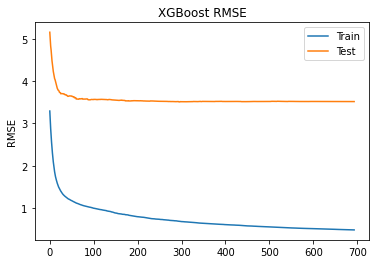

In [34]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error

y_pred = xgbr.predict(X_valid)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

print('MSE: %.2f' % mse)
print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE: 12.31
RMSE: 3.51
MSE (rounded): 12.32
RMSE (rounded): 3.51


In [36]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_13.pkl'

# save
pickle.dump(xgbr, open(dest + file_name, 'wb'))

In [ ]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_13.pkl'
# load
xgbr = pickle.load(open(dest + file_name, "rb"))

[18:22:52] INFO: /workspace/src/learner.cc:370: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


In [37]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_9_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,month,year,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,5,5037,11,2015,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,1,1052,1092,1294,991,954,1445,25,110,119,54,105,65,21346,24604,23616,19872,22261,49726,0.0,0.9287,1.951
1,5,5320,11,2015,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000
2,5,5233,11,2015,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,3,1052,1092,1294,991,954,0,42,80,150,37,119,0,21346,24604,23616,19872,22261,0,0.0,1.4290,1.657
3,5,5232,11,2015,34,599.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,0,1052,1092,1294,0,0,0,28,48,65,0,0,0,21346,24604,23616,0,0,0,0.0,0.3333,1.093
4,5,5268,11,2015,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000


In [38]:
test_pred = xgbr.predict(test_df)
print(test_pred)

[ 3.6087579e-01 -3.2281876e-04  6.0524774e-01 ...  5.1305181e-01
 -6.1273575e-04  4.4743097e-01]


In [39]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [40]:
sample.item_cnt_month = np.around(test_pred)
sample.head()

,ID,item_cnt_month
0,0,0.0
1,1,-0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [41]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + 'submission #28.csv', index=False)

In [42]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

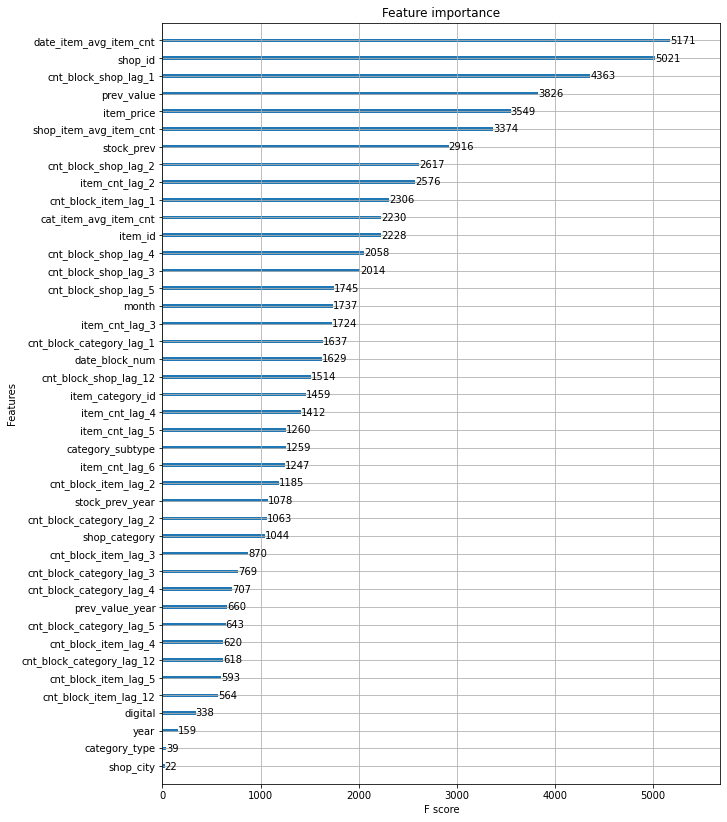

In [43]:
plot_features(xgbr, (10, 14))